<a href="https://colab.research.google.com/github/AbishekArunachalam/Image-Captioning--Deep-Learning-model-/blob/master/DeepLearningAT3_Building_an_Image_Captioning_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Image captioning model

**Image captioning** task consists of two models - A image based **Convolutional Neural Network (CNN)** model and a language based **Recurrent Neural Network (RNN)** model. The CNN model extracts the important features in the image and feeds into the RNN model.



##
# Install packages

In [0]:
# Install the packages
!pip install -U -q PyDrive
!pip install keras

### Import packages

In [0]:
# Import packages
import os
import keras
import numpy as np
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from keras.applications.resnet50 import preprocess_input, decode_predictions

### Mount data

In [0]:
# Mount data from Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
google_auth = GoogleAuth()
google_auth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(google_auth)

 # Extract features from CNN

Load VGG model with pretrained weights.

In [0]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# load the model
model = VGG16()

# summarise model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Remove the last layer from the VGG model.

In [0]:
# remove the prediction layer from the model
model.layers.pop()

# summarise model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

There are no non-trainable parameters as we have removed the prediction layer.

In [0]:
# instantiate model with input and output tensor
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

# summarize model
print(model.summary()) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
'''
extracts features from each photo in the directory

Input:
path of the directory

Returns:
dictionary of file name as key and feature as value

'''
def extract_features(directory):
  
  # instantiate a dictionary object to store the features
  features = dict()
  
  for name in listdir(directory):
    
    # load an image from file
    filename = directory + '/' + name
    
    # resize to 224*224 image to train on VGG model
    image = load_img(filename, target_size=(224, 224))
    
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    
    # reshape array to take images in batches
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # normalise array based on the model
    image = preprocess_input(image)
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # get the names of the image file
    image_id = name.split('.')[0]
    
    # store file name as key and extracted features as value
    features[image_id] = feature
    
  return features

In [0]:
# extract features from all images
directory = 'gdrive/My Drive/data/flickr8k_Dataset'
features = extract_features(directory)

print('Extracted Features: %d' % len(features))

# save features in a pickle file
dump(features, open('features.pkl', 'wb'))

KeyboardInterrupt: ignored

# Clean text in captions

In [0]:
import string

'''
load doc into memory

Input:
directory of the file

Returns:
text in the file
'''
def load_doc(filename):
  
	# open the file as read only
	file = open(filename, 'r')
  
	# read all text
	text = file.read()
  
	# close the file
	file.close()
  
	return text

In [0]:
'''
# extract descriptions for images

Input: 
text in Flickr8k.token.txt file

Returns:
dictionary of image_id and image descriptions
'''

def load_descriptions(doc):
  
  mapping = dict()
  
  # loop through each line
  for line in doc.split('\n'):
    
    # split line by white space
    tokens = line.split()
    
    # skip lines that has length <2
    if len(line) < 2:
      print(line)
      continue
    
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]
    
    # remove extension from file name
    image_id = image_id.split('.')[0]
    
    # convert description tokens back to string with white spaces
    image_desc = ' '.join(image_desc)
    
    # create a list of description for each image_id
    if image_id not in mapping:
      # instantiate list
      mapping[image_id] = list()
      
    # store description
    mapping[image_id].append(image_desc)
    
  return mapping

In [0]:
'''
# clean descriptions

Input:
dictionary of image_id and image descriptions
'''

def clean_descriptions(descriptions):
  
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
  
  # loop through the dictionary
	for key, desc_list in descriptions.items():
    
    # loop through each item in the list
		for i in range(len(desc_list)):
      
			desc = desc_list[i]
      
			# tokenize
			desc = desc.split()
      
			# convert to lower case
			desc = [word.lower() for word in desc]
      
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
      
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
      
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
      
			# store as string
			desc_list[i] =  ' '.join(desc)

In [0]:
'''
# convert the loaded descriptions into a vocabulary of words

Input:
dictionary of image_id and image descriptions

Returns:
list of words in the descriptions

'''

def to_vocabulory(descriptions):
  
  # build a set of a descriptions
  all_desc = set()
  
  # loop through each key in desc dictionary
  for key in descriptions.keys():
    
    # add words in the description to list
    [all_desc.update(d.split()) for d in descriptions[key]]
    
  return all_desc

In [0]:
'''
# save descriptions to file, one per line

Input:
descriptions - dictionary of image_id and image descriptions
filename - name of the file to save descriptions
'''
def save_descriptions(descriptions, filename):
  
  # instantiate an empty list
	lines = list()
  
  # loop through description dictionary
	for key, desc_list in descriptions.items():
    
    # loop through description list
		for desc in desc_list:
      
      # concatenate image_id and cleaned descriptions 
      # in a single line and add it to list
			lines.append(key + ' ' + desc)
  
  # create new line for each list item
	data = '\n'.join(lines)
  
  # create file with write permission
	file = open(filename, 'w')
  
  # write data to file
	file.write(data)
  
  # close file
	file.close()

In [0]:
filename = 'gdrive/My Drive/data/flickr8k_text/Flickr8k.token.txt'

# load descriptions
doc = load_doc(filename)

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

# clean descriptions
clean_descriptions(descriptions)

# summarize vocabulary
vocabulary = to_vocabulory(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save to file
save_descriptions(descriptions, 'descriptions.txt')


Loaded: 8092 
Vocabulary Size: 8763


# Image captioning RNN model

### Load train data

In [0]:
import numpy as np
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

'''
# extract image identifier from training set

Input:
directory of the file

Returns:
list of image identifiers
'''
def load_set(filename):
  
  # load document
  doc = load_doc(filename)
  
  # create an empty list
  dataset = list()
  
  # process line by line
  for line in doc.split('\n'):
    
    # skip empty lines
    if len(line) < 1:
      continue
      
    # get the image identifier
    identifier = line.split('.')[0]
    
    # append identifier to the list
    dataset.append(identifier)
   
  return set(dataset)


'''
create description dictionary for the training set

Input:
filename - directory of the description file
dataset - list of image identifiers in training set

Returns:
dictionary of descriptions
'''
def load_training_descriptions(filename, dataset):
  
	# load document
	doc = load_doc(filename)
  
	descriptions = dict()
  
	for line in doc.split('\n'):
    
		# split line by white space
		tokens = line.split()
    
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
    
		# skip images not in the set
		if image_id in dataset:
      
			# create list
			if image_id not in descriptions:
        
				descriptions[image_id] = list()
        
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      
			# store
			descriptions[image_id].append(desc)
      
	return descriptions


from pickle import load

'''
filter features of the images in training set

Input:
filename - directory of the features pickle file
dataset - list of image identifiers in training set

Returns:
dictionary of features of images in training set
'''
def load_photo_features(filename, dataset):
  
	# load all features
	all_features = load(open(filename, 'rb'))
  
	# filter features
	features = {k: all_features[k] for k in dataset}
  
	return features

'''
extract captions from train descriptions

Input:
descriptions - descriptions in training set

Returns:
all_desc - all text caption in descriptions
'''
def to_lines(descriptions):
  
  all_desc = list()
  
  # extract caption text with key
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
    
  return all_desc


from keras.preprocessing.text import Tokenizer

'''
fit a tokenizer given caption descriptions

Input:
descriptions - descriptions in training set

Returns:
tokenizer - word tokens
'''
def create_tokenizer(descriptions):
  
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  
  return tokenizer


'''
calculate the length of the description with the most words

Input:
descriptions - descriptions

Returns:
max length
'''
def max_length(descriptions):
  
	lines = to_lines(descriptions)
  
	return max(len(d.split()) for d in lines)


'''
create sequences of image features, input sequences and output words for an image

Input:
tokenizer - corpora of tokens
max_length - max length of word description
desc_list - list of image descriptions
features - feaures of images

Returns:
X1 - features of images
X2 - input sequence
y - output sequence
'''

def create_sequences(tokenizer, max_length, desc_list, features):
  
  X1, X2, y = list(), list(), list()
  
  # loop through each description of the image
  for desc in desc_list:
    
    # encode the sequence
    seq = tokenizer.texts_to_sequences([desc])[0]
    
    # split sequence into multiple X,y pairs
    for i in range(1, len(seq)):
      
      # split into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
      
      # pad input sequence
      in_seq = pad_sequences([in_seq], maxlen= max_length)[0]
      
      # encode output sequence
      out_seq = to_categorical([out_seq], num_classes= vocab_size)[0]
      
      X1.append(features)
      X2.append(in_seq)
      y.append(out_seq)
      
  return array(X1), array(X2), array(y)


'''
define the captioning model

Input:
vocab_size - 
max_length - max lenght of words in dictionary

Returns:
Model
'''
def define_model(vocab_size, max_length):
  
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	model.summary()
	plot_model(model, to_file='model.png', show_shapes=True)
	return model


'''
data generator, intended to be used in a call to model.fit_generator()

Input:
descriptions - description of image
features - image as features
tokenizer - tokens
max_length - max length of description

'''
def data_generator(descriptions, features, tokenizer, max_length):
  
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			feature = features[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, feature)
			yield [[in_img, in_seq], out_word]

## Save model weights

In [0]:
# load training dataset (6K)
filename = 'gdrive/My Drive/data/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# descriptions
train_descriptions = load_training_descriptions('gdrive/My Drive/data/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# features of photos in training set
train_features = load_photo_features('gdrive/My Drive/data/features.pkl', train)
print('Photos: train=%d' % len(train_features))


# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1

print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
# define the model
model = define_model(vocab_size, max_length)

# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
  
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, use_multiprocessing=True)
	
  # save model
	model.save('model_' + str(i) + '.h5')

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 256)      1940224     input_9[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 4096)         0           input_8[0][0]                    
______

Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()


KeyboardInterrupt: ignored

## Evaluate model

In [0]:
'''
map an integer to a word

Input:
integer - list of integers for word prediction
tokenizer - word token object

Return:
in_text - predicted caption of the image
'''

def word_for_id(integer, tokenizer):
  
	for word, index in tokenizer.word_index.items():
    
		if index == integer:
      
			return word
    
	return None

'''
map an integer to a word

Input:
integer - list of integers for word prediction
tokenizer - word token object

Return:
in_text - predicted caption of the image
'''
def generate_desc(model, tokenizer, features, max_length):
	
  # seed the generation process
	in_text = 'startseq'
  
	# iterate over the whole length of the sequence
	for i in range(max_length):
    
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
    
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
    
		# predict next word
		yhat = model.predict([features,sequence], verbose=0)
    
		# convert probability to integer
		yhat = np.argmax(yhat)
    
		# map integer to word
		word = word_for_id(yhat, tokenizer)
    
		# stop if we cannot map the word
		if word is None:
			break
      
		# append as input for generating the next word
		in_text += ' ' + word
    
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
      
	return in_text

In [0]:
'''
map an integer to a word

Input:
model - list of integers for word prediction
descriptions - word token object
features - features of the images
tokenizer - word tokens
max_length - max length of description
'''


def evaluate_model(model, descriptions, features, tokenizer, max_length):
  
	actual, predicted = list(), list()
  
	# step over the whole set
	for key, desc_list in descriptions.items():
    
		# generate description
		yhat = generate_desc(model, tokenizer, features[key], max_length)
    
		# store actual and predicted
		references = [d.split() for d in desc_list]
    
		actual.append(references)
    
		predicted.append(yhat.split())
    
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [0]:
# load test set
filename = 'gdrive/My Drive/data/flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_training_descriptions('gdrive/My Drive/data/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('gdrive/My Drive/data/features.pkl', test)
print('Photos: test=%d' % len(test_features))


from keras.models import load_model

# load the model
filename = 'gdrive/My Drive/data/model_11.h5'

model = load_model(filename)

# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.560356
BLEU-2: 0.303543
BLEU-3: 0.197983
BLEU-4: 0.085495


In [0]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
 
# evaluate model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
 
# load training dataset (6K)
filename = 'gdrive/My Drive/data/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('gdrive/My Drive/data/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)


# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
 
# load test set
filename = 'gdrive/My Drive/data/flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('gdrive/My Drive/data/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('gdrive/My Drive/data/features.pkl', test)
print('Photos: test=%d' % len(test_features))
 
# load the model
filename = 'gdrive/My Drive/data/model_11.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.560356
BLEU-2: 0.303543
BLEU-3: 0.197983
BLEU-4: 0.085495


In [0]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
 
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, feature, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([feature,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
 
  # calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# load the tokenizer
tokenizer = load(open('gdrive/My Drive/data/tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('gdrive/My Drive/data/model_11.h5')
# load and prepare the photograph

feature = extract_features('gdrive/My Drive/data/flickr8k_Dataset/1000268201_693b08cb0e.jpg')
# generate description
description = generate_desc(model, tokenizer, feature, max_length)

description = description.replace('startseq', '')
description = description.replace('endseq', '')
description = description.capitalize()

In [0]:
from keras.preprocessing import image

img = "gdrive/My Drive/data/flickr8k_Dataset/3320032226_63390d74a6.jpg"

def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    return im
  
def get_encoding(filename):
    image = preprocessing(filename)
    pred = model.predict(image)
    pred = np.reshape(pred, pred.shape[1])
    return pred

test_img = get_encoding(img)

def predict_captions(image):
    start_word = ["startseq"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "endseq" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)


def beam_search_predictions(image, beam_index = 3):
    start = [word_2_indices["startseq"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            preds = model.predict([np.array([image]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:] #Top n prediction
            
            for w in word_preds: #new list so as to feed it to model again
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:] # Top n words
    
    start_word = start_word[-1][0]
    intermediate_caption = [indices_2_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption


Beam_Search_index_3 = beam_search_predictions(test_img, beam_index=3)
Beam_Search_index_5 = beam_search_predictions(test_img, beam_index=5)
Beam_Search_index_7 = beam_search_predictions(test_img, beam_index=7)

ValueError: ignored

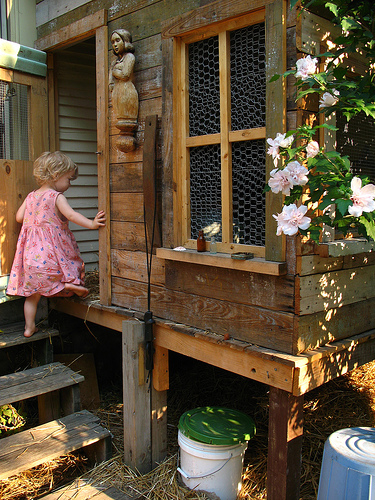

 man in pink shirt is standing on the street 


In [0]:
img = "gdrive/My Drive/data/flickr8k_Dataset/1000268201_693b08cb0e.jpg"

z = Image(img)
display(z)

print(description)